# Teste supervisionado com dados tunados

In [14]:
#import os pacotes utilizados
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

#selecionando atributos 
from sklearn.feature_selection import RFECV

#resample
from sklearn.utils import resample

#ESCALONAMENTO DE DADOS
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import RobustScaler

#SELECIONANDO MELHOR MODELO
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import make_classification
from scipy.stats import randint as sp_randint
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import cross_val_score

#Evaluating
import seaborn as sns; sns.set()

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score 
from sklearn.metrics import precision_score, recall_score 
from sklearn.metrics import f1_score

#EXPORTAR ARVORE
from sklearn.tree import export_graphviz
import os

#CURVA ROC
%matplotlib inline
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict 
from sklearn.metrics import roc_auc_score

#REDUÇÃO DE DIMENSIONALIDADE
from sklearn.decomposition import PCA

#exibindo todas as colunas
pd.set_option('display.max_columns', None)

#definicao de funcoes que serao utilizadas
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            
def plot_roc_curve(fpr, tpr, label=None):    
    plt.plot(fpr, tpr, linewidth=2, label=label)    
    plt.plot([0, 1], [0, 1], 'k--')    
    plt.axis([0, 1, 0, 1])   
    plt.xlabel('False Positive Rate')    
    plt.ylabel('True Positive Rate')
    
#definindo score
from sklearn.metrics import make_scorer
from sklearn.metrics import cohen_kappa_score

def score_evasao(y_true, y_pred): 
    tp = confusion_matrix(y_true, y_pred)[0, 0]
    fn = confusion_matrix(y_true, y_pred)[0, 1]
    
    return tp/(tp+fn)
   
#SELECIONANDO MELHOR MODEL RF
def make_RF(Xtrain, ytrain):
    #cria a randomforest 
    #forest_clf = RandomForestClassifier(oob_score=True, n_jobs=-1) 
    forest_clf = RandomForestClassifier(n_jobs=-1) 

    param_grid_forest = {'max_depth': [3, 5, None],
                  'max_features': ['auto', 'sqrt', 'log2'],
                  'n_estimators': [10, 30, 60, 100, 200],
                  'criterion': ["gini", "entropy"], 
                   #'class_weight': [{0:10, 1:.1}, 'balanced'] #foi utilizado quando os dados estavam desbalanceados
                    }

    
    #utilizando o score definido de acordo com a evasao
    #print(score_evasao(ytest, ypred_forest))
    #se = make_scorer(score_evasao)

    #seleciona o melhor modelo de acordo com os parâmetros
    #grid_search_forest = GridSearchCV(estimator=forest_clf, param_grid=param_grid_forest, cv=10)    
    #grid_search_forest = GridSearchCV(estimator=forest_clf, param_grid=param_grid_forest, scoring = 'f1')
    #grid_search_forest = GridSearchCV(estimator=forest_clf, param_grid=param_grid_forest, scoring = 'roc_auc')
    
    kappa_scorer = make_scorer(cohen_kappa_score)
    grid_search_forest = GridSearchCV(estimator=forest_clf, param_grid=param_grid_forest, scoring = kappa_scorer, cv=10)
    
    grid_search_forest.fit(Xtrain, ytrain)
    print(grid_search_forest.best_params_)
    print(grid_search_forest.best_estimator_)
    
    #mostra os 5 melhores modelos
    report(grid_search_forest.cv_results_, 3)    
    
    return grid_search_forest.best_estimator_

def evaluating(model, ytest, ypred, Xtest):
    #Evaluating
    mat = confusion_matrix(ytest, ypred)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
    plt.xlabel('true label')
    plt.ylabel('predicted label');
    
    s = mat[0][1]/(mat[0][0]+mat[0][1])
    print("Valor de falso positivo:"+str(s))
    
    #evaluating
    print("Cálculo de índices de avaliação:")
    
    print("Precisão: %f; Recall: %f, F1: %f" % (precision_score(ytest, ypred), 
                                                recall_score(ytest, ypred), 
                                                f1_score(ytest, ypred) ))

    #precisao
    print('Precisão CV:')
    scores = cross_val_score(model, Xtest, ytest, cv=10)
    accuracy = np.mean(scores)
    print(scores)
    print(accuracy)

    #CURVA ROC
    fig = plt.figure()
    y_probas = cross_val_predict(model, Xtest, ytest, cv=10, method="predict_proba") 

    y_scores = y_probas[:, 1]   # score = proba of positive class 
    fpr, tpr, thresholds = roc_curve(ytest, y_scores)

    plot_roc_curve(fpr, tpr) 
    plt.show()
    print(roc_auc_score(ytest, y_scores))
    
def feature_ranking(Xtest, model):
    #exibe os atributos mais importantes
    importances = model.feature_importances_
    std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]

    # Print the feature ranking
    print("Feature ranking:")

    for f in range(Xtest.shape[1]):
        print("%d. feature %d [%s] (%f)" % (f + 1, indices[f], Xtest.columns[indices[f]], importances[indices[f]]))

    # Plot the feature importances of the forest
    plt.figure()
    plt.title("Feature importances")
    plt.bar(range(Xtest.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
    plt.xticks(range(Xtest.shape[1]), indices)
    plt.xlim([-1, Xtest.shape[1]])
    plt.show()    
    
def evaluating_2(model, ytest, ypred, X, y, Xtest):
    #Evaluating
    plt.figure()
    mat = confusion_matrix(ytest, ypred)
    sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
    plt.xlabel('true label')
    plt.ylabel('predicted label');
    
    s = mat[0][1]/(mat[0][0]+mat[0][1])
    print("Valor de falso positivo:"+str(s))
    
    #evaluating
    print(precision_score(ytest, ypred))
    print(recall_score(ytest, ypred))

    #evaluating
    print(precision_score(ytest, ypred))
    print(recall_score(ytest, ypred))
    print(f1_score(ytest, ypred))

    #precisao
    print('Precisao')
    scores = cross_val_score(model, X, y, cv=10)
    accuracy = np.mean(scores)
    print(scores)
    print(accuracy)

#limpando os NaN devido ao RF
def preparing_data(dados):
    print(dados.shape)
    dados = dados.dropna()
    print(dados.shape)
    
    #configura os dados de entrada e saída
    y = dados.classe
    X = dados

    del X['classe']
    X.shape    
    
    #binazira os dados devido aos atributos categoricos 
    dados_dummies = pd.get_dummies(X, drop_first=True)
    dados_dummies.shape

    #remove atributos inconistentes
    dados_clean = dados_dummies.replace([np.inf, -np.inf], np.nan)
    dados_clean = dados_clean.dropna(axis=1, how='all')
    print(dados_clean.info())
    
    return (dados_clean, y)

In [3]:
dados_tunning = pd.read_json('dados/dados_workflow_ivan.json')

dados_tunning.head(2)

,LnguaPortuguesaeLiteraturaI90H,LnguaPortuguesaeLiteraturaI90H_dependencia,LnguaPortuguesaeLiteraturaI90H_freq,MatemticaI120H,MatemticaI120H_dependencia,MatemticaI120H_freq,acompanhamento,aluno_exclusivo_rede_publica,artificial,classe,conceito,conceito_freq,descricao,descricao_area_residencial,descricao_companhia_domiciliar,descricao_estado_civil,descricao_historico,descricao_imovel,descricao_mae_escolaridade,descricao_pai_escolaridade,descricao_raca,descricao_responsavel_escolaridade,descricao_responsavel_financeiro,descricao_trabalho,id,idade,pessoa_fisica__sexo,possui_necessidade_especial,qnt_pc,qnt_salarios,qtd_pessoas_domicilio,sigla,tempo_entre_conclusao_ingresso
0,68.0,0,100.0,66.0,0,100.0,0,False,0,1,B,A,Matriculado,Urbana,Mãe,Solteiro(a),Técnico de Nivel Médio em Informática,Alugado,Ensino fundamental incompleto,Ensino fundamental incompleto,Branca,Ensino fundamental incompleto,Mãe,Não informado,457884597605,15,F,False,0,1,2,LAJ,1
1,73.0,1,100.0,36.0,1,91.0,0,False,1,0,R,R,Cancelado,Urbana,Mãe,Solteiro(a),Técnico de Nível Médio em Meio Ambiente,Alugado,Ensino fundamental incompleto,Ensino fundamental incompleto,Parda,Ensino fundamental incompleto,Mãe,Não informado,458436647741,17,M,False,1,1,2,SPP,2


# Modelo 01: utilizando todos os dados

no cenário abaixo foram utilizados todos os dados incluindo as notas as quais os valores NAN foram preenchidas com -1, a fim de não serem limpados. 

o resultado como visto foi bastante instatisfatório, uma vez que o falto positivo (prever que não evadiu, mas o aluno evadiu) tem um valor muito elevado, sendo o pior erro no problema. É interessante notar que os índices de avaliação tradicionais (precision, recall, f1) foram bons, o que parece contraditório. A explicação se deve ao fato das classes estarem bastante desbalanceadas. Para a seleção do modelo foi utilizado o médodo kappa_scorer o que conseguiu trazer a tona o problema do erro elevado de falso positivo  

In [3]:
dados = dados_tunning.copy()

dados = dados[[
       'LnguaPortuguesaeLiteraturaI90H',
       'LnguaPortuguesaeLiteraturaI90H_dependencia',
       'LnguaPortuguesaeLiteraturaI90H_freq', 'MatemticaI120H',
       'MatemticaI120H_dependencia', 'MatemticaI120H_freq', 'acompanhamento',
       'aluno_exclusivo_rede_publica', 'artificial', 'classe', 'conceito',
       'conceito_freq', 'descricao_area_residencial',
       'descricao_companhia_domiciliar', 'descricao_estado_civil',
       'descricao_historico', 'descricao_imovel', 'descricao_mae_escolaridade',
       'descricao_pai_escolaridade', 'descricao_raca',
       'descricao_responsavel_escolaridade',
       'descricao_responsavel_financeiro', 'descricao_trabalho', 'idade',
       'pessoa_fisica__sexo', 'possui_necessidade_especial', 'qnt_pc',
       'qnt_salarios', 'qtd_pessoas_domicilio', 'sigla',
       'tempo_entre_conclusao_ingresso'    
]]

#convertendo os NaN das notas em -1 para usar o RF 
dados['LnguaPortuguesaeLiteraturaI90H'].fillna(-1, inplace=True)
dados['LnguaPortuguesaeLiteraturaI90H_dependencia'].fillna(-1, inplace=True)
dados['LnguaPortuguesaeLiteraturaI90H_freq'].fillna(-1, inplace=True)

dados['MatemticaI120H'].fillna(-1, inplace=True)
dados['MatemticaI120H_dependencia'].fillna(-1, inplace=True)
dados['MatemticaI120H_freq'].fillna(-1, inplace=True)

(8908, 31)
(8908, 31)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 8908 entries, 0 to 998
Columns: 151 entries, LnguaPortuguesaeLiteraturaI90H to sigla_ZN
dtypes: bool(2), float64(4), int64(9), uint8(136)
memory usage: 2.1 MB
None


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


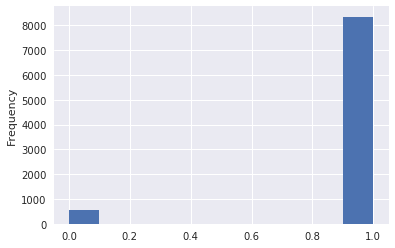

In [4]:
X, y = preparing_data(dados)
y.plot.hist()

In [5]:
#dividir os dados para treino e teste. default é 25% p teste
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=0, stratify = y)

In [6]:
#seleciona o melhor modelo
model_forest_completo = make_RF(Xtrain, ytrain)
ypred_forest = model_forest_completo.predict(Xtest)

{'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 10}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Model with rank: 1
Mean validation score: 0.598 (std: 0.059)
Parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 10}

Model with rank: 2
Mean validation score: 0.586 (std: 0.076)
Parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 'auto', 'n_estimators': 10}

Model with rank: 3
Mean validation score: 0.577 (std: 0.052)
Parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 60}

Model with ra

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Valor de falso positivo:0.5827338129496403
Cálculo de índices de avaliação:
Precisão: 0.962291; Recall: 0.989943, F1: 0.975921
Precisão CV:
[0.94618834 0.96412556 0.95964126 0.95067265 0.94618834 0.97757848
 0.94618834 0.94170404 0.95045045 0.97285068]
0.9555588124699177


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


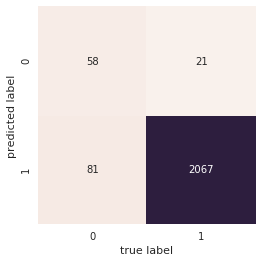

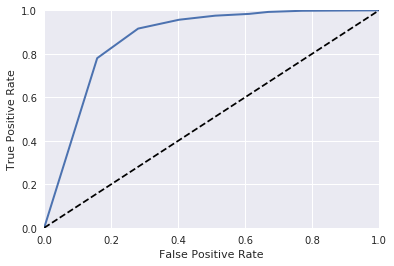

0.8701073623859532
Feature ranking:
1. feature 0 [LnguaPortuguesaeLiteraturaI90H] (0.108878)
2. feature 3 [MatemticaI120H] (0.066783)
3. feature 5 [MatemticaI120H_freq] (0.060685)
4. feature 15 [conceito_I] (0.059031)
5. feature 2 [LnguaPortuguesaeLiteraturaI90H_freq] (0.044520)
6. feature 17 [conceito_R] (0.038645)
7. feature 9 [idade] (0.028260)
8. feature 23 [descricao_area_residencial_Não informado] (0.022514)
9. feature 19 [conceito_freq_I] (0.021467)
10. feature 1 [LnguaPortuguesaeLiteraturaI90H_dependencia] (0.019997)
11. feature 126 [descricao_trabalho_Não informado] (0.019135)
12. feature 13 [qtd_pessoas_domicilio] (0.017908)
13. feature 20 [conceito_freq_R] (0.016873)
14. feature 6 [acompanhamento] (0.016348)
15. feature 141 [sigla_MC] (0.016103)
16. feature 12 [qnt_salarios] (0.015963)
17. feature 14 [tempo_entre_conclusao_ingresso] (0.015155)
18. feature 11 [qnt_pc] (0.014160)
19. feature 77 [descricao_mae_escolaridade_Ensino fundamental incompleto] (0.009965)
20. feature 9

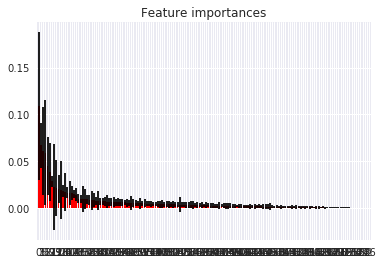

In [7]:
#avaliacao do modelo
evaluating(model_forest_completo, ytest, ypred_forest, Xtest)

feature_ranking(Xtest, model_forest_completo)

# Modelo 02: aumentando a quantidade de instâncias da classe de evasão

para tentar resolver o problema da classe desbalanceada será acrescentada novas instâncias a base da classe 0, a partir da duplicação de instâncias já contidas na base. Foram removidos as instâncias com dados gerados de forma artificial e as instâncias com notas NAN 

In [18]:
dados = dados_tunning.copy()

dados = dados[[
       'LnguaPortuguesaeLiteraturaI90H',
       'LnguaPortuguesaeLiteraturaI90H_dependencia',
       'LnguaPortuguesaeLiteraturaI90H_freq', 'MatemticaI120H',
       'MatemticaI120H_dependencia', 'MatemticaI120H_freq', 'acompanhamento',
       'aluno_exclusivo_rede_publica', 'artificial', 'classe', 'conceito',
       'conceito_freq', 'descricao_area_residencial',
       'descricao_companhia_domiciliar', 'descricao_estado_civil',
       'descricao_historico', 'descricao_imovel', 'descricao_mae_escolaridade',
       'descricao_pai_escolaridade', 'descricao_raca',
       'descricao_responsavel_escolaridade',
       'descricao_responsavel_financeiro', 'descricao_trabalho', 'idade',
       'pessoa_fisica__sexo', 'possui_necessidade_especial', 'qnt_pc',
       'qnt_salarios', 'qtd_pessoas_domicilio', 'sigla',
       'tempo_entre_conclusao_ingresso'    
]]

dados = dados[dados.artificial == 0]
dados.classe.value_counts()

1    7369
0     349
Name: classe, dtype: int64

In [19]:
Xtrain, Xtest, ytrain, ytest = train_test_split(dados, dados.classe, random_state=0, stratify = dados.classe)

In [21]:
# separa as classes majoritária e minoritária 
df_majority = Xtrain[Xtrain.classe==1]
df_minority = Xtrain[Xtrain.classe==0]
 
# Upsample classe minoritária
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample com reposição
                                 n_samples=df_majority.shape[0],    # iguala a quantidade da classe majoritária
                                 random_state=0) 
 
# junta as duas classes
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
print(df_upsampled.classe.value_counts())
#dados = 

1    5526
0    5526
Name: classe, dtype: int64


In [22]:
print(df_upsampled.shape)
print(Xtest.shape)

(11052, 31)
(1930, 31)


In [34]:
Xtrain, ytrain = preparing_data(df_upsampled)
Xtest2, ytest  = preparing_data(Xtest)

#ocorreu um problema que havia atributos q havia no treino, mas nao havia no teste devido a binarizacao dos elementos categoricos
#abaixo é consertado esse problema removendo os atributos que nao estao em comuns
print(Xtrain.shape)
print(Xtest2.shape)

res = np.setdiff1d(Xtrain.columns, Xtest2.columns)
for c in res:
    print(c)
    del Xtrain[c]

print(Xtrain.shape)
print(Xtest2.shape)    
    
#dividir os dados para treino e teste. default é 25% p teste
#Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=0, stratify = y)

(11052, 31)
(9585, 31)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 9585 entries, 5781 to 6589
Columns: 149 entries, LnguaPortuguesaeLiteraturaI90H to sigla_ZN
dtypes: bool(2), float64(4), int64(9), uint8(134)
memory usage: 2.3 MB
None
(1930, 31)
(1497, 31)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1497 entries, 7727 to 5596
Columns: 145 entries, LnguaPortuguesaeLiteraturaI90H to sigla_ZN
dtypes: bool(2), float64(4), int64(9), uint8(130)
memory usage: 356.7 KB
None
(9585, 149)
(1497, 145)
descricao_area_residencial_Comunidade Quilombola
descricao_area_residencial_Não informado
descricao_imovel_Pensionato ou Alojamento
descricao_trabalho_Pescador
(9585, 145)
(1497, 145)


In [35]:
#seleciona o melhor modelo
model_forest_up = make_RF(Xtrain, ytrain)

{'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'n_estimators': 200}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Model with rank: 1
Mean validation score: 0.992 (std: 0.004)
Parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'n_estimators': 200}

Model with rank: 2
Mean validation score: 0.992 (std: 0.003)
Parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 'log2', 'n_estimators': 200}

Model with rank: 3
Mean validation score: 0.992 (std: 0.003)
Parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'n_estimators': 100}

Model wi

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Valor de falso positivo:0.5882352941176471
Cálculo de índices de avaliação:
Precisão: 0.965659; Recall: 0.995751, F1: 0.980474
Precisão CV:
[0.94701987 0.95364238 0.94666667 0.95333333 0.94666667 0.95302013
 0.94630872 0.95973154 0.94630872 0.94630872]
0.9499006770671287


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


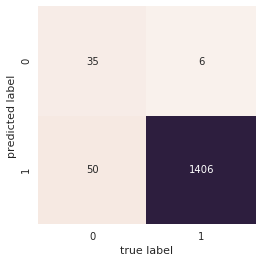

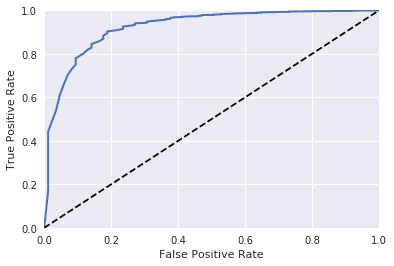

0.9231294784202635
Feature ranking:
1. feature 0 [LnguaPortuguesaeLiteraturaI90H] (0.151945)
2. feature 3 [MatemticaI120H] (0.139596)
3. feature 17 [conceito_R] (0.083542)
4. feature 5 [MatemticaI120H_freq] (0.052790)
5. feature 15 [conceito_I] (0.048031)
6. feature 2 [LnguaPortuguesaeLiteraturaI90H_freq] (0.033158)
7. feature 9 [idade] (0.031992)
8. feature 13 [qtd_pessoas_domicilio] (0.018555)
9. feature 16 [conceito_O] (0.017546)
10. feature 12 [qnt_salarios] (0.016588)
11. feature 11 [qnt_pc] (0.015153)
12. feature 14 [tempo_entre_conclusao_ingresso] (0.014851)
13. feature 1 [LnguaPortuguesaeLiteraturaI90H_dependencia] (0.014208)
14. feature 4 [MatemticaI120H_dependencia] (0.013508)
15. feature 6 [acompanhamento] (0.011548)
16. feature 19 [conceito_freq_R] (0.010950)
17. feature 10 [possui_necessidade_especial] (0.009158)
18. feature 7 [aluno_exclusivo_rede_publica] (0.007618)
19. feature 125 [pessoa_fisica__sexo_M] (0.007558)
20. feature 73 [descricao_mae_escolaridade_Ensino médio

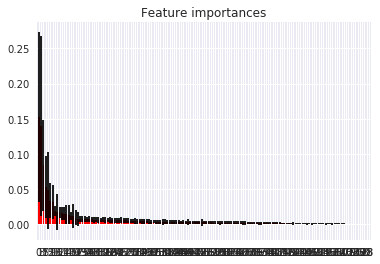

In [36]:
ypred_forest = model_forest_up.predict(Xtest2)

#avaliacao do modelo
evaluating(model_forest_up, ytest, ypred_forest, Xtest2)

feature_ranking(Xtest2, model_forest_up)

# Modelo 03: diminuindo a quantidade de instâncias da classe 01

In [37]:
dados = dados_tunning.copy()

dados = dados[[
       'LnguaPortuguesaeLiteraturaI90H',
       'LnguaPortuguesaeLiteraturaI90H_dependencia',
       'LnguaPortuguesaeLiteraturaI90H_freq', 'MatemticaI120H',
       'MatemticaI120H_dependencia', 'MatemticaI120H_freq', 'acompanhamento',
       'aluno_exclusivo_rede_publica', 'artificial', 'classe', 'conceito',
       'conceito_freq', 'descricao_area_residencial',
       'descricao_companhia_domiciliar', 'descricao_estado_civil',
       'descricao_historico', 'descricao_imovel', 'descricao_mae_escolaridade',
       'descricao_pai_escolaridade', 'descricao_raca',
       'descricao_responsavel_escolaridade',
       'descricao_responsavel_financeiro', 'descricao_trabalho', 'idade',
       'pessoa_fisica__sexo', 'possui_necessidade_especial', 'qnt_pc',
       'qnt_salarios', 'qtd_pessoas_domicilio', 'sigla',
       'tempo_entre_conclusao_ingresso'    
]] 

dados = dados[dados.artificial == 0]
print(dados.classe.value_counts())

# Separate majority and minority classes
df_majority = dados[dados.classe==1]
df_minority = dados[dados.classe==0]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=df_minority.shape[0],     # to match minority class
                                 random_state=0) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_minority, df_majority_downsampled])
 
# Display new class counts
df_upsampled.classe.value_counts()
#dados = df_upsampled

1    7369
0     349
Name: classe, dtype: int64


1    349
0    349
Name: classe, dtype: int64

In [39]:
X, y = preparing_data(df_upsampled)

#dividir os dados para treino e teste. default é 25% p teste
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=0, stratify = y)

(698, 31)
(613, 31)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 613 entries, 1028 to 31
Columns: 143 entries, LnguaPortuguesaeLiteraturaI90H to sigla_ZN
dtypes: bool(2), float64(4), int64(9), uint8(128)
memory usage: 144.9 KB
None


{'criterion': 'entropy', 'max_depth': None, 'max_features': 'auto', 'n_estimators': 200}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Model with rank: 1
Mean validation score: 0.767 (std: 0.086)
Parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 'auto', 'n_estimators': 200}

Model with rank: 2
Mean validation score: 0.763 (std: 0.089)
Parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 'log2', 'n_estimators': 100}

Model with rank: 3
Mean validation score: 0.758 (std: 0.070)
Parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 10

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


[0.82352941 0.875      0.8125     0.73333333 1.         0.6
 0.8        0.73333333 0.93333333 0.93333333]
0.824436274509804


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


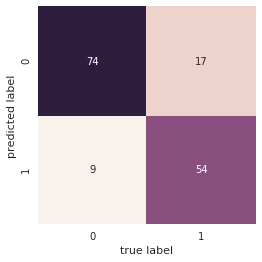

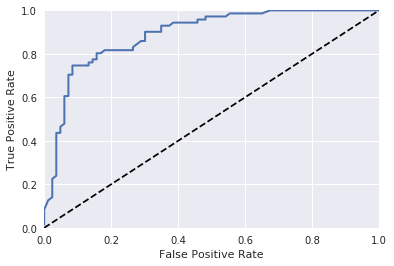

0.8889360257933141
Feature ranking:
1. feature 3 [MatemticaI120H] (0.152994)
2. feature 0 [LnguaPortuguesaeLiteraturaI90H] (0.135891)
3. feature 17 [conceito_R] (0.085075)
4. feature 15 [conceito_I] (0.058443)
5. feature 5 [MatemticaI120H_freq] (0.047436)
6. feature 2 [LnguaPortuguesaeLiteraturaI90H_freq] (0.034506)
7. feature 16 [conceito_O] (0.029525)
8. feature 9 [idade] (0.023862)
9. feature 13 [qtd_pessoas_domicilio] (0.018199)
10. feature 11 [qnt_pc] (0.017430)
11. feature 4 [MatemticaI120H_dependencia] (0.014660)
12. feature 1 [LnguaPortuguesaeLiteraturaI90H_dependencia] (0.014228)
13. feature 12 [qnt_salarios] (0.013202)
14. feature 14 [tempo_entre_conclusao_ingresso] (0.013039)
15. feature 129 [sigla_CNAT] (0.010622)
16. feature 6 [acompanhamento] (0.009366)
17. feature 19 [conceito_freq_R] (0.008981)
18. feature 10 [possui_necessidade_especial] (0.008880)
19. feature 71 [descricao_mae_escolaridade_Ensino médio completo] (0.008277)
20. feature 123 [pessoa_fisica__sexo_M] (0.00

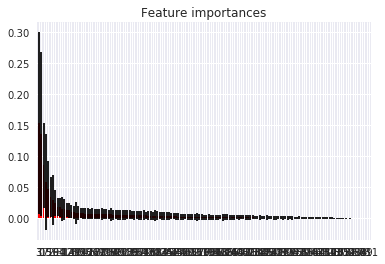

In [40]:
#seleciona o melhor modelo
model_forest_min = make_RF(Xtrain, ytrain)
ypred_forest = model_forest_min.predict(Xtest)

#avaliacao do modelo
evaluating(model_forest_min, ytest, ypred_forest, Xtest)

feature_ranking(Xtest, model_forest_min)

# Selecionando atributos do melhor modelo

o melhor modelo verificado foi utilizando o downsample

In [42]:
from sklearn.feature_selection import RFECV

selector = RFECV(model_forest_min, cv=10, n_jobs=-1)
selector.fit(X, y)

best_columns = list(X.columns[selector.support_])
print("Best Columns \n"+"-"*12+"\n{}\n".format(best_columns))

Best Columns 
------------
['LnguaPortuguesaeLiteraturaI90H', 'LnguaPortuguesaeLiteraturaI90H_dependencia', 'LnguaPortuguesaeLiteraturaI90H_freq', 'MatemticaI120H', 'MatemticaI120H_dependencia', 'MatemticaI120H_freq', 'acompanhamento', 'idade', 'possui_necessidade_especial', 'qnt_pc', 'qnt_salarios', 'qtd_pessoas_domicilio', 'tempo_entre_conclusao_ingresso', 'conceito_I', 'conceito_O', 'conceito_R', 'descricao_companhia_domiciliar_Pais', 'descricao_pai_escolaridade_Ensino médio incompleto', 'descricao_responsavel_financeiro_Mãe', 'pessoa_fisica__sexo_M', 'sigla_CNAT', 'sigla_MC']



In [44]:
selector = RFECV(model_forest_min, cv=10, n_jobs=-1)
selector.fit(Xtest, ytest)

best_columns = list(Xtest.columns[selector.support_])
print("Best Columns \n"+"-"*12+"\n{}\n".format(best_columns))

Best Columns 
------------
['LnguaPortuguesaeLiteraturaI90H', 'LnguaPortuguesaeLiteraturaI90H_dependencia', 'LnguaPortuguesaeLiteraturaI90H_freq', 'MatemticaI120H', 'MatemticaI120H_dependencia', 'MatemticaI120H_freq', 'acompanhamento', 'aluno_exclusivo_rede_publica', 'idade', 'possui_necessidade_especial', 'qnt_pc', 'qnt_salarios', 'qtd_pessoas_domicilio', 'tempo_entre_conclusao_ingresso', 'conceito_I', 'conceito_O', 'conceito_R', 'conceito_freq_R', 'descricao_area_residencial_Urbana', 'descricao_companhia_domiciliar_Mãe', 'descricao_companhia_domiciliar_Pais', 'descricao_historico_Técnico de Nivel Médio em Informática', 'descricao_historico_Técnico de Nível Médio em Edificações', 'descricao_imovel_Próprio', 'descricao_mae_escolaridade_Ensino fundamental completo', 'descricao_mae_escolaridade_Ensino fundamental incompleto', 'descricao_mae_escolaridade_Ensino médio completo', 'descricao_pai_escolaridade_Ensino fundamental incompleto', 'descricao_pai_escolaridade_Ensino médio completo', 

# Modelo 04: modelo com seleção de atributos 

In [47]:
atributos_01 = ['LnguaPortuguesaeLiteraturaI90H', 
                'LnguaPortuguesaeLiteraturaI90H_dependencia', 
                'LnguaPortuguesaeLiteraturaI90H_freq', 
                'MatemticaI120H', 
                'MatemticaI120H_dependencia', 
                'MatemticaI120H_freq', 
                'acompanhamento', 
                'idade', 
                'possui_necessidade_especial', 
                'qnt_pc', 
                'qnt_salarios', 
                'qtd_pessoas_domicilio', 
                'tempo_entre_conclusao_ingresso', 
                'conceito_I', 
                'conceito_O', 
                'conceito_R', 
                'descricao_companhia_domiciliar_Pais', 
                'descricao_pai_escolaridade_Ensino médio incompleto', 
                'descricao_responsavel_financeiro_Mãe', 
                'pessoa_fisica__sexo_M', 
                'sigla_CNAT', 
                'sigla_MC']

atributos_02 = ['LnguaPortuguesaeLiteraturaI90H', 
                'LnguaPortuguesaeLiteraturaI90H_dependencia', 
                'LnguaPortuguesaeLiteraturaI90H_freq', 
                'MatemticaI120H', 
                'MatemticaI120H_dependencia', 
                'MatemticaI120H_freq', 
                'acompanhamento', 
                'aluno_exclusivo_rede_publica', 
                'idade', 
                'possui_necessidade_especial', 
                'qnt_pc', 
                'qnt_salarios', 
                'qtd_pessoas_domicilio', 
                'tempo_entre_conclusao_ingresso', 
                'conceito_I', 
                'conceito_O', 
                'conceito_R', 
                'conceito_freq_R', 
                'descricao_area_residencial_Urbana', 
                'descricao_companhia_domiciliar_Mãe', 
                'descricao_companhia_domiciliar_Pais', 
                'descricao_historico_Técnico de Nivel Médio em Informática', 
                'descricao_historico_Técnico de Nível Médio em Edificações', 
                'descricao_imovel_Próprio', 
                'descricao_mae_escolaridade_Ensino fundamental completo', 
                'descricao_mae_escolaridade_Ensino fundamental incompleto', 
                'descricao_mae_escolaridade_Ensino médio completo', 
                'descricao_pai_escolaridade_Ensino fundamental incompleto', 
                'descricao_pai_escolaridade_Ensino médio completo', 
                'descricao_pai_escolaridade_Ensino médio incompleto', 
                'descricao_raca_Branca', 
                'descricao_raca_Parda', 
                'descricao_raca_Preta', 
                'descricao_responsavel_escolaridade_Ensino fundamental incompleto', 
                'descricao_responsavel_escolaridade_Ensino médio completo', 
                'descricao_responsavel_escolaridade_Ensino médio incompleto', 
                'descricao_responsavel_financeiro_Mãe',
                'descricao_responsavel_financeiro_Pai', 
                'descricao_trabalho_Autônomo', 
                'descricao_trabalho_Empresa privada', 
                'descricao_trabalho_Nunca trabalhou', 
                'descricao_trabalho_Não está trabalhando', 
                'pessoa_fisica__sexo_M', 
                'sigla_MC', 
                'sigla_SGA']

print(Xtest.columns.size)
print(len(atributos_01))
print(len(atributos_02))
print(np.setdiff1d(atributos_01, atributos_02))
print(np.setdiff1d(atributos_02, atributos_01))

143
22
45
['sigla_CNAT']
['aluno_exclusivo_rede_publica' 'conceito_freq_R'
 'descricao_area_residencial_Urbana' 'descricao_companhia_domiciliar_Mãe'
 'descricao_historico_Técnico de Nivel Médio em Informática'
 'descricao_historico_Técnico de Nível Médio em Edificações'
 'descricao_imovel_Próprio'
 'descricao_mae_escolaridade_Ensino fundamental completo'
 'descricao_mae_escolaridade_Ensino fundamental incompleto'
 'descricao_mae_escolaridade_Ensino médio completo'
 'descricao_pai_escolaridade_Ensino fundamental incompleto'
 'descricao_pai_escolaridade_Ensino médio completo'
 'descricao_raca_Branca' 'descricao_raca_Parda' 'descricao_raca_Preta'
 'descricao_responsavel_escolaridade_Ensino fundamental incompleto'
 'descricao_responsavel_escolaridade_Ensino médio completo'
 'descricao_responsavel_escolaridade_Ensino médio incompleto'
 'descricao_responsavel_financeiro_Pai' 'descricao_trabalho_Autônomo'
 'descricao_trabalho_Empresa privada' 'descricao_trabalho_Nunca trabalhou'
 'descricao_t

In [48]:
Xtrain_red = Xtrain[atributos_02]
Xtest_red  = Xtest[atributos_02]

In [52]:
#seleciona o melhor modelo
model_forest_red = make_RF(Xtrain_red, ytrain)

ypred_forest = model_forest_red.predict(Xtest_red)


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


Valor de falso positivo:0.0963855421686747
Cálculo de índices de avaliação:
Precisão: 0.864407; Recall: 0.718310, F1: 0.784615
Precisão CV:
[0.88235294 0.875      0.8125     0.73333333 1.         0.6
 0.86666667 0.73333333 0.93333333 0.86666667]
0.8303186274509805


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


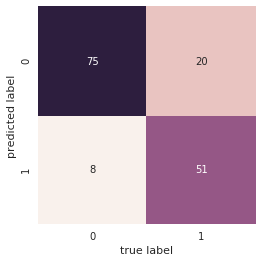

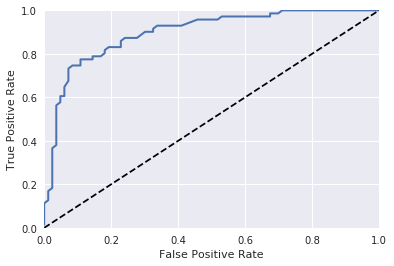

0.8972509757339215
Feature ranking:
1. feature 3 [MatemticaI120H] (0.186656)
2. feature 0 [LnguaPortuguesaeLiteraturaI90H] (0.170768)
3. feature 16 [conceito_R] (0.100102)
4. feature 5 [MatemticaI120H_freq] (0.058639)
5. feature 14 [conceito_I] (0.053413)
6. feature 2 [LnguaPortuguesaeLiteraturaI90H_freq] (0.040150)
7. feature 15 [conceito_O] (0.029341)
8. feature 8 [idade] (0.029142)
9. feature 12 [qtd_pessoas_domicilio] (0.022358)
10. feature 10 [qnt_pc] (0.022296)
11. feature 11 [qnt_salarios] (0.019865)
12. feature 4 [MatemticaI120H_dependencia] (0.017878)
13. feature 1 [LnguaPortuguesaeLiteraturaI90H_dependencia] (0.016407)
14. feature 13 [tempo_entre_conclusao_ingresso] (0.016069)
15. feature 42 [pessoa_fisica__sexo_M] (0.010519)
16. feature 20 [descricao_companhia_domiciliar_Pais] (0.009808)
17. feature 23 [descricao_imovel_Próprio] (0.009724)
18. feature 6 [acompanhamento] (0.009416)
19. feature 43 [sigla_MC] (0.008812)
20. feature 33 [descricao_responsavel_escolaridade_Ensino 

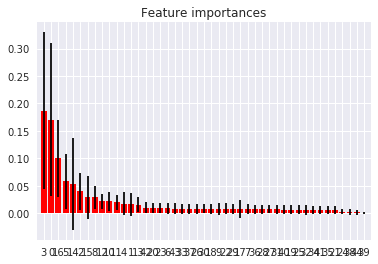

In [53]:
#avaliacao do modelo
evaluating(model_forest_red, ytest, ypred_forest, Xtest_red)

feature_ranking(Xtest_red, model_forest_red)

In [54]:
Xtrain_red = Xtrain[atributos_01]
Xtest_red  = Xtest[atributos_01]

{'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'n_estimators': 100}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Model with rank: 1
Mean validation score: 0.789 (std: 0.077)
Parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'n_estimators': 100}

Model with rank: 2
Mean validation score: 0.789 (std: 0.065)
Parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 'auto', 'n_estimators': 200}

Model with rank: 3
Mean validation score: 0.789 (std: 0.052)
Parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 'log2', 'n_estimators': 60}

Model 

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


[0.88235294 1.         0.75       0.73333333 1.         0.6
 0.8        0.73333333 0.93333333 0.86666667]
0.8299019607843137


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


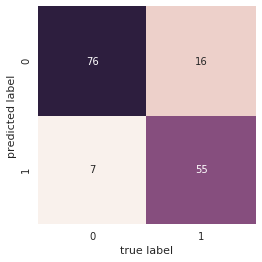

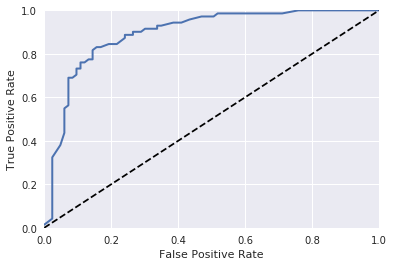

0.8937722721873409
Feature ranking:
1. feature 3 [MatemticaI120H] (0.232028)
2. feature 0 [LnguaPortuguesaeLiteraturaI90H] (0.195793)
3. feature 15 [conceito_R] (0.137646)
4. feature 5 [MatemticaI120H_freq] (0.066893)
5. feature 13 [conceito_I] (0.059757)
6. feature 2 [LnguaPortuguesaeLiteraturaI90H_freq] (0.042428)
7. feature 7 [idade] (0.032188)
8. feature 9 [qnt_pc] (0.024833)
9. feature 11 [qtd_pessoas_domicilio] (0.024475)
10. feature 10 [qnt_salarios] (0.020621)
11. feature 1 [LnguaPortuguesaeLiteraturaI90H_dependencia] (0.020466)
12. feature 12 [tempo_entre_conclusao_ingresso] (0.018974)
13. feature 20 [sigla_CNAT] (0.018239)
14. feature 14 [conceito_O] (0.017570)
15. feature 4 [MatemticaI120H_dependencia] (0.016644)
16. feature 19 [pessoa_fisica__sexo_M] (0.011632)
17. feature 8 [possui_necessidade_especial] (0.011437)
18. feature 16 [descricao_companhia_domiciliar_Pais] (0.011055)
19. feature 18 [descricao_responsavel_financeiro_Mãe] (0.010518)
20. feature 6 [acompanhamento] (

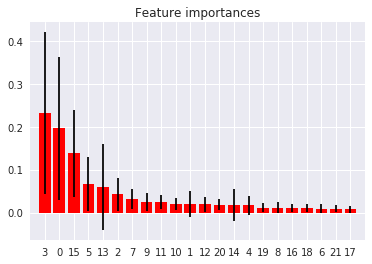

In [55]:
#seleciona o melhor modelo
model_forest_red = make_RF(Xtrain_red, ytrain)
ypred_forest = model_forest_red.predict(Xtest_red)

#avaliacao do modelo
evaluating(model_forest_red, ytest, ypred_forest, Xtest_red)

feature_ranking(Xtest_red, model_forest_red)

# Modelo 05: comparandos várias ML

# Modelos sem atributos gerados após entradada no IF
Foram desconsiderado todos os atributos (nota, frequência, acompanhamento) que são gerados após a entrada no IF.

1    7369
0     349
Name: classe, dtype: int64
(7718, 22)
(7718, 22)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 7718 entries, 0 to 998
Columns: 137 entries, aluno_exclusivo_rede_publica to sigla_ZN
dtypes: bool(2), int64(6), uint8(129)
memory usage: 1.4 MB
None
{'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 10}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Model with rank: 1
Mean validation score: 0.009 (std: 0.028)
Parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'n_estimators': 10}

Model with rank: 2
Mean validation score: 0.007 (std: 0.021)
Para

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


[0.94845361 0.95360825 0.95360825 0.95336788 0.94818653 0.95336788
 0.94818653 0.95833333 0.953125   0.95833333]
0.9528570578049607


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


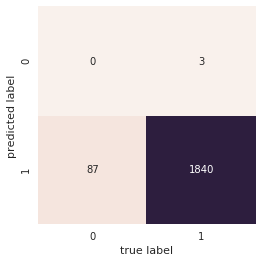

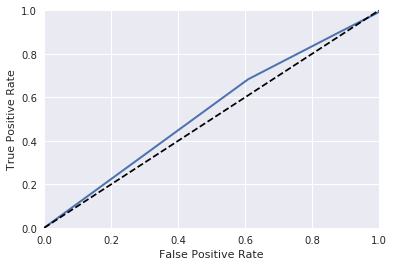

0.5356365496036573
Feature ranking:
1. feature 6 [qtd_pessoas_domicilio] (0.060285)
2. feature 2 [idade] (0.050139)
3. feature 5 [qnt_salarios] (0.036027)
4. feature 7 [tempo_entre_conclusao_ingresso] (0.034854)
5. feature 4 [qnt_pc] (0.034470)
6. feature 117 [pessoa_fisica__sexo_M] (0.023336)
7. feature 64 [descricao_mae_escolaridade_Ensino médio completo] (0.022149)
8. feature 110 [descricao_trabalho_Nunca trabalhou] (0.020934)
9. feature 103 [descricao_responsavel_financeiro_Pai] (0.019840)
10. feature 111 [descricao_trabalho_Não está trabalhando] (0.019373)
11. feature 99 [descricao_responsavel_financeiro_Mãe] (0.019201)
12. feature 16 [descricao_companhia_domiciliar_Pais] (0.019018)
13. feature 85 [descricao_raca_Parda] (0.018601)
14. feature 3 [possui_necessidade_especial] (0.018567)
15. feature 61 [descricao_imovel_Próprio] (0.017171)
16. feature 63 [descricao_mae_escolaridade_Ensino fundamental incompleto] (0.015755)
17. feature 82 [descricao_raca_Branca] (0.015119)
18. feature

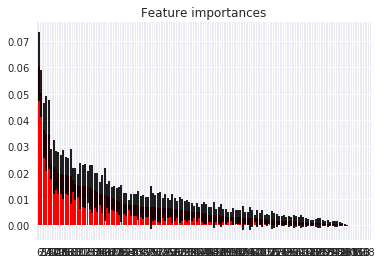

In [4]:
dados = dados_tunning.copy()

dados = dados[[
       'aluno_exclusivo_rede_publica', 'artificial', 'classe', 
       'descricao_area_residencial',
       'descricao_companhia_domiciliar', 'descricao_estado_civil',
       'descricao_historico', 'descricao_imovel', 'descricao_mae_escolaridade',
       'descricao_pai_escolaridade', 'descricao_raca',
       'descricao_responsavel_escolaridade',
       'descricao_responsavel_financeiro', 'descricao_trabalho', 'idade',
       'pessoa_fisica__sexo', 'possui_necessidade_especial', 'qnt_pc',
       'qnt_salarios', 'qtd_pessoas_domicilio', 'sigla',
       'tempo_entre_conclusao_ingresso'    
]]

dados = dados[dados.artificial == 0]
print(dados.classe.value_counts())

X, y = preparing_data(dados)

#dividir os dados para treino e teste. default é 25% p teste
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=0, stratify = y)

#seleciona o melhor modelo
model_forest_completo = make_RF(Xtrain, ytrain)
ypred_forest = model_forest_completo.predict(Xtest)

#avaliacao do modelo
evaluating(model_forest_completo, ytest, ypred_forest, Xtest)

feature_ranking(Xtest, model_forest_completo)

# Modelo utilizando downsample

1    7369
0     349
Name: classe, dtype: int64
(698, 22)
(698, 22)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 698 entries, 1028 to 31
Columns: 132 entries, aluno_exclusivo_rede_publica to sigla_ZN
dtypes: bool(2), int64(6), uint8(124)
memory usage: 124.1 KB
None
{'criterion': 'gini', 'max_depth': 5, 'max_features': 'log2', 'n_estimators': 200}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Model with rank: 1
Mean validation score: 0.224 (std: 0.127)
Parameters: {'criterion': 'gini', 'max_depth': 5, 'max_features': 'log2', 'n_estimators': 200}

Model with rank: 2
Mean validation score: 0.212 (std: 0.130)
Parameter

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


[0.66666667 0.77777778 0.61111111 0.5        0.66666667 0.5
 0.66666667 0.47058824 0.6875     0.3125    ]
0.5859477124183006


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


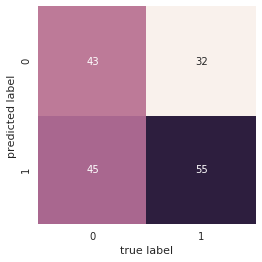

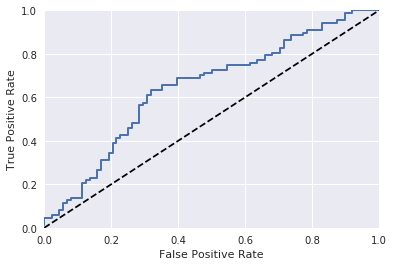

0.6442006269592476
Feature ranking:
1. feature 2 [idade] (0.072332)
2. feature 4 [qnt_pc] (0.041508)
3. feature 0 [aluno_exclusivo_rede_publica] (0.037586)
4. feature 6 [qtd_pessoas_domicilio] (0.037101)
5. feature 3 [possui_necessidade_especial] (0.034151)
6. feature 5 [qnt_salarios] (0.031996)
7. feature 7 [tempo_entre_conclusao_ingresso] (0.027259)
8. feature 9 [descricao_area_residencial_Urbana] (0.025306)
9. feature 123 [sigla_MO] (0.024171)
10. feature 60 [descricao_mae_escolaridade_Ensino médio completo] (0.021920)
11. feature 85 [descricao_responsavel_escolaridade_Ensino médio completo] (0.018781)
12. feature 130 [sigla_SPP] (0.017783)
13. feature 70 [descricao_pai_escolaridade_Ensino médio completo] (0.016481)
14. feature 12 [descricao_companhia_domiciliar_Outros] (0.015836)
15. feature 42 [descricao_historico_Técnico de Nível Médio em Meio Ambiente] (0.015722)
16. feature 8 [descricao_area_residencial_Rural] (0.014445)
17. feature 91 [descricao_responsavel_escolaridade_Pós gr

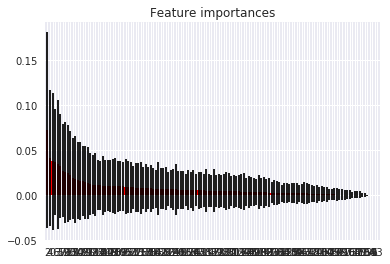

In [6]:
dados = dados_tunning.copy()

dados = dados[[
       'aluno_exclusivo_rede_publica', 'artificial', 'classe', 
       'descricao_area_residencial',
       'descricao_companhia_domiciliar', 'descricao_estado_civil',
       'descricao_historico', 'descricao_imovel', 'descricao_mae_escolaridade',
       'descricao_pai_escolaridade', 'descricao_raca',
       'descricao_responsavel_escolaridade',
       'descricao_responsavel_financeiro', 'descricao_trabalho', 'idade',
       'pessoa_fisica__sexo', 'possui_necessidade_especial', 'qnt_pc',
       'qnt_salarios', 'qtd_pessoas_domicilio', 'sigla',
       'tempo_entre_conclusao_ingresso'    
]]

dados = dados[dados.artificial == 0]
print(dados.classe.value_counts())

# Separate majority and minority classes
df_majority = dados[dados.classe==1]
df_minority = dados[dados.classe==0]
 
# Downsample majority class
df_majority_downsampled = resample(df_majority, 
                                 replace=False,    # sample without replacement
                                 n_samples=df_minority.shape[0],     # to match minority class
                                 random_state=0) # reproducible results
 
# Combine majority class with upsampled minority class
df_downsampled = pd.concat([df_minority, df_majority_downsampled])
 
# Display new class counts
df_downsampled.classe.value_counts()

X, y = preparing_data(df_downsampled)

#dividir os dados para treino e teste. default é 25% p teste
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=0, stratify = y)

#seleciona o melhor modelo
model_forest_down = make_RF(Xtrain, ytrain)
ypred_forest = model_forest_down.predict(Xtest)

#avaliacao do modelo
evaluating(model_forest_down, ytest, ypred_forest, Xtest)

feature_ranking(Xtest, model_forest_down)

# Selecionando atributos

In [7]:
selector = RFECV(model_forest_down, cv=10, n_jobs=-1)
selector.fit(X, y)

best_columns = list(X.columns[selector.support_])
print("Best Columns \n"+"-"*12+"\n{}\n".format(best_columns))

Best Columns 
------------
['idade', 'qnt_pc', 'qnt_salarios', 'qtd_pessoas_domicilio']



In [8]:
selector = RFECV(model_forest_down, cv=10, n_jobs=-1)
selector.fit(Xtest, ytest)

best_columns = list(Xtest.columns[selector.support_])
print("Best Columns \n"+"-"*12+"\n{}\n".format(best_columns))

Best Columns 
------------
['idade', 'qnt_pc', 'qnt_salarios', 'qtd_pessoas_domicilio', 'tempo_entre_conclusao_ingresso']



# Modelo com seleção de atributos

In [9]:
atributos = ['idade', 'qnt_pc', 'qnt_salarios', 'qtd_pessoas_domicilio', 'tempo_entre_conclusao_ingresso']

In [10]:
Xtrain_red = Xtrain[atributos]
Xtest_red  = Xtest[atributos]

{'criterion': 'entropy', 'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 10}
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=5, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
Model with rank: 1
Mean validation score: 0.193 (std: 0.111)
Parameters: {'criterion': 'entropy', 'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 10}

Model with rank: 2
Mean validation score: 0.181 (std: 0.103)
Parameters: {'criterion': 'gini', 'max_depth': 3, 'max_features': 'auto', 'n_estimators': 30}

Model with rank: 3
Mean validation score: 0.181 (std: 0.115)
Parameters: {'criterion': 'entropy', 'max_depth': 5, 'max_features': 'sqrt', 'n_estimators': 30}

Valor de falso posi

/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


[0.61111111 0.83333333 0.66666667 0.66666667 0.83333333 0.72222222
 0.61111111 0.47058824 0.75       0.375     ]
0.6540032679738562


/home/ubuntu/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


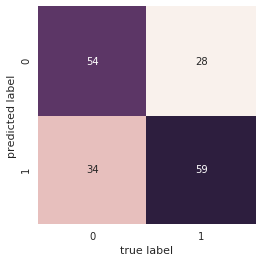

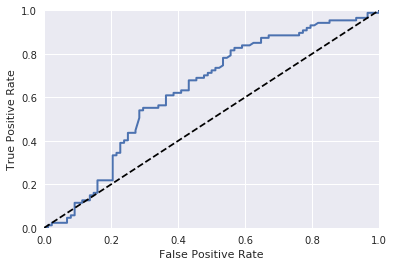

0.6329022988505747
Feature ranking:
1. feature 0 [idade] (0.352804)
2. feature 3 [qtd_pessoas_domicilio] (0.229221)
3. feature 1 [qnt_pc] (0.174477)
4. feature 2 [qnt_salarios] (0.144527)
5. feature 4 [tempo_entre_conclusao_ingresso] (0.098970)


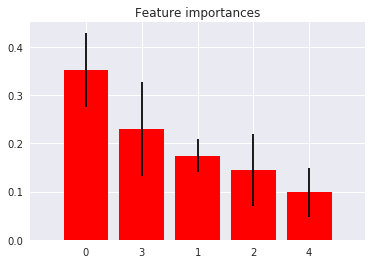

In [11]:
#seleciona o melhor modelo
model_forest_red = make_RF(Xtrain_red, ytrain)
ypred_forest = model_forest_red.predict(Xtest_red)

#avaliacao do modelo
evaluating(model_forest_red, ytest, ypred_forest, Xtest_red)

feature_ranking(Xtest_red, model_forest_red)

In [1]:
#FIM